# 🌿 CropSenseAI - Clean AI Plant Health Advisor 
An optimized system designed to leverages both image and voice inputs to deliver accurate plant health predictions.
Combining advanced AI models with a rule-based knowledge base, it analyzes visual features and audio descriptions to 
diagnose conditions like diseases, nutrient deficiencies, and pests. The platform ensures easy deployment without 
relying on ONNX mobile conversion, focusing on streamlined, flexible health assessment workflows. 
CropSenseAI empowers users to monitor and maintain plant vitality with reliable, multimodal insights.

# 🌿 1. Start with Essential Imports
   setup and readiness

In [1]:
import subprocess
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"    # Hide most TF/XLA logs
os.environ['XLA_FLAGS'] = '--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1'
os.environ["BITSANDBYTES_NOWELCOME"] = "1"  # Suppress warning
os.environ["LOAD_IN_4BIT_FORCE"] = "1"      # Force Unsloth to try loading in 4-bit

# 📋 2. Declare Required Libraries
 Install only required modules

In [2]:
def install_dependencies():
    """Install required packages for Kaggle"""
    packages = [
        'torch>=2.0.0',
        'opencv-python',
        'pillow',
        'librosa',
        'matplotlib',
        'numpy',
        'pandas',
        'onnx',
        'onnxruntime',
        'bitsandbytes',
        'transformers>=4.36.0',
        'accelerate',
        'sentencepiece',
        'protobuf==3.20.*',
        "trl"
    ]
    
    print("🔄 Installing dependencies...")
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q","--no-deps", package])
            print(f"✅ {package} installed")
        except subprocess.CalledProcessError:
            print(f"⚠️ Failed to install {package}")

# 🔍 3. Set Up Unsloth Framework
   Add unsloth setups

In [3]:
# Try to install Unsloth for Kaggle
import subprocess, sys, os

try:
     if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        print("🔄 Installing Unsloth and Unsloth Zoo (no deps)...")

        # Install unsloth
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "-q", "--no-deps",
            "git+https://github.com/unslothai/unsloth.git"
        ])

        # Install unsloth_zoo
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "-q", "--no-deps",
            "git+https://github.com/unslothai/unsloth_zoo.git"
        ])
     else:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "-q", "--no-deps", "unsloth"
        ])
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "-q", "--no-deps", "unsloth_zoo"
        ])
    
     print("✅ Unsloth and Zoo installed successfully")
except Exception as e:
     print("⚠️ Installation failed - using fallback")
     print(e)


🔄 Installing Unsloth and Unsloth Zoo (no deps)...
✅ Unsloth and Zoo installed successfully


# 📥 4. Install Dependencies
  Commonly used 

In [4]:
# Install dependencies
install_dependencies()

🔄 Installing dependencies...
✅ torch>=2.0.0 installed
✅ opencv-python installed
✅ pillow installed
✅ librosa installed
✅ matplotlib installed
✅ numpy installed
✅ pandas installed
✅ onnx installed
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 99.3 MB/s eta 0:00:00
✅ onnxruntime installed
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 25.3 MB/s eta 0:00:00
✅ bitsandbytes installed
✅ transformers>=4.36.0 installed
✅ accelerate installed
✅ sentencepiece installed
✅ protobuf==3.20.* installed
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 12.1 MB/s eta 0:00:00
✅ trl installed


# 🧠 5. Load Core Modules
   Loading key modules

In [5]:
# Core imports
import torch
import numpy as np
import pandas as pd
from PIL import Image
import librosa
import cv2
import json
import matplotlib.pyplot as plt
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
print("✅ Imported all core modules successfully!")

E0000 00:00:1753952772.154650      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753952772.221574      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Imported all core modules successfully!


# 6. ⚙️ Check Unsloth & ONNX Availability
  General system check

In [6]:
# Check for Unsloth
try:
    from unsloth import FastLanguageModel
    UNSLOTH_AVAILABLE = True
    print("✅ Unsloth available")
except ImportError:
    UNSLOTH_AVAILABLE = False
    print("⚠️ Using standard transformers")

# Check for ONNX
try:
    import onnx
    import onnxruntime as ort
    ONNX_AVAILABLE = True
    print("✅ ONNX available")
except ImportError:
    ONNX_AVAILABLE = False
    print("⚠️ ONNX not available")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Unsloth available
✅ ONNX available


# 7. 🔧 Create: PlantHealthAdvisor Logic Block
### 🌿 PlantHealthAdvisor – Class Overview 

 - Initializes a plant health advisory system that supports image, audio, and text input for diagnosing plant conditions.

 - Loads AI language models using either Unsloth (4-bit optimized) or standard Hugging Face transformers for generating health assessments and advice.

 - Processes plant images to extract visual features such as brightness, contrast, green dominance, and color variance to assess plant health.

 - Transcribes audio descriptions using OpenAI Whisper, allowing voice-based plant condition reporting.

 - Analyzes health conditions by combining AI-generated insight with rule-based matching against known symptom-treatments for issues like fungal disease, nutrient deficiency, pests, or water stress.

 - Generates tailored treatment recommendations based on analysis, with confidence scores derived from image quality and condition matches.

 - Saves analysis results and visualizations (JSON + PNG) to a timestamped output directory for record-keeping and user-friendly summaries.

 - Supports ONNX model conversion for lightweight, mobile-friendly deployment of the advisory system.

 - Provides a demo image generator to simulate plant health conditions (e.g., healthy, sick, pest damage) for testing and training.

 - Designed for flexible deployment across devices, with GPU support, rule-based fallbacks, and dynamic multimodal inputs (image, audio, and text).

In [7]:
class PlantHealthAdvisor:
    """Clean, focused plant health analysis system"""
    
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = None
        self.tokenizer = None
        self.audio_processor = None
        
        # Create output directory
        self.output_dir = Path("./plant_analysis_output")
        self.output_dir.mkdir(exist_ok=True)
        
        # Plant health knowledge base
        self.health_conditions = {
            'healthy': {
                'symptoms': ['green leaves', 'upright growth', 'no discoloration'],
                'treatment': 'Continue current care. Monitor regularly for changes.'
            },
            'fungal_disease': {
                'symptoms': ['white spots', 'black spots', 'yellowing', 'powdery coating'],
                'treatment': 'Apply fungicide spray. Improve air circulation. Reduce watering frequency.'
            },
            'nutrient_deficiency': {
                'symptoms': ['yellow leaves', 'stunted growth', 'pale color', 'brown edges'],
                'treatment': 'Apply balanced fertilizer. Check soil pH. Ensure proper nutrients.'
            },
            'pest_damage': {
                'symptoms': ['holes in leaves', 'chewed edges', 'visible insects'],
                'treatment': 'Use organic pesticide. Remove affected parts. Check for pest eggs.'
            },
            'water_stress': {
                'symptoms': ['wilting', 'drooping', 'dry soil', 'brown tips'],
                'treatment': 'Adjust watering schedule. Check soil moisture. Improve drainage.'
            }
        }
        
        print("🌿 PlantHealthAdvisor initialized")
    
    def load_model(self):
        """Load the best available model"""
        try:
            if UNSLOTH_AVAILABLE:
                return self._load_unsloth_model()
            else:
                return self._load_standard_model()
        except Exception as e:
            logger.error(f"Model loading failed: {e}")
            return False
    
    def _load_unsloth_model(self):
        """Load Unsloth model for better performance"""
        try:
            model_name = "unsloth/gemma-2-2b-it-bnb-4bit"  # Smaller model for Kaggle
            print(f"🔄 Loading Unsloth model: {model_name}")
            
            self.model, self.tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_name,
                max_seq_length=1024,
                load_in_4bit=True,
            )
            
            FastLanguageModel.for_inference(self.model)
            print("✅ Unsloth model loaded successfully")
            return True
            
        except Exception as e:
            print(f"❌ Unsloth model failed: {e}")
            return self._load_standard_model()
        
    def _load_standard_model(self):
        """Load standard transformers model"""
        try:
            model_name = "microsoft/DialoGPT-medium"
            print(f"🔄 Loading standard model: {model_name}")
            
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
            
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                device_map="auto" if torch.cuda.is_available() else None
            )
            
            print("✅ Standard model loaded successfully")
            return True
            
        except Exception as e:
            logger.error(f"Standard model loading failed: {e}")
            return False
    
    def load_audio_processor(self):
        """Load audio processing pipeline"""
        try:
            self.audio_processor = pipeline(
                "automatic-speech-recognition",
                model="openai/whisper-tiny.en",
                device=0 if torch.cuda.is_available() else -1
            )
            print("✅ Audio processor loaded")
            return True
        except Exception as e:
            print(f"⚠️ Audio processor failed: {e}")
            return False
    
    def process_image(self, image_path):
        """Extract features from plant image"""
        try:
            # Load and resize image
            image = Image.open(image_path).convert('RGB')
            image_resized = image.resize((224, 224))
            image_array = np.array(image_resized)
            
            # Extract basic visual features
            features = {
                'brightness': float(np.mean(image_array)),
                'contrast': float(np.std(image_array)),
                'green_dominance': float(np.mean(image_array[:,:,1]) / np.mean(image_array)),
                'color_variance': float(np.var(image_array.reshape(-1, 3), axis=0).mean()),
                'image_shape': image.size
            }
            
            return features, image
            
        except Exception as e:
            logger.error(f"Image processing failed: {e}")
            return None, None
    
    def process_audio(self, audio_path):
        """Convert audio to text description"""
        try:
            if self.audio_processor is None:
                if not self.load_audio_processor():
                    return "Audio processing not available"
            
            # Process audio file
            result = self.audio_processor(audio_path)
            text = result.get('text', '')
            
            print(f"🎤 Audio transcribed: {text}")
            return text
            
        except Exception as e:
            logger.error(f"Audio processing failed: {e}")
            return f"Audio processing error: {str(e)}"
    
    def analyze_plant_health(self, image_path, audio_path=None, text_description=""):
        """Main analysis function"""
        try:
            print("🌿 Starting plant health analysis...")
            
            # Process image
            image_features, image = self.process_image(image_path)
            if image_features is None:
                return {"error": "Failed to process image"}
            
            # Process audio if provided
            audio_text = ""
            if audio_path and os.path.exists(audio_path):
                audio_text = self.process_audio(audio_path)
            
            # Combine descriptions
            full_description = f"{text_description} {audio_text}".strip()
            
            # Generate AI analysis
            analysis = self._generate_analysis(image_features, full_description)
            
            # Get recommendations
            recommendations = self._get_recommendations(analysis, image_features)
            
            # Create result
            result = {
                'timestamp': datetime.now().isoformat(),
                'image_path': str(image_path),
                'audio_path': str(audio_path) if audio_path else None,
                'image_features': image_features,
                'description': full_description,
                'analysis': analysis,
                'recommendations': recommendations,
                'confidence': self._calculate_confidence(analysis, image_features)
            }
            
            # Save results
            self._save_results(result)
            
            # Create visualization
            self._create_visualization(image, result)
            
            print("✅ Analysis complete!")
            return result
            
        except Exception as e:
            logger.error(f"Analysis failed: {e}")
            return {"error": str(e)}
    
    def _generate_analysis(self, image_features, description):
        """Generate AI analysis of plant health"""
        try:
            if self.model is None:
                return "Model not loaded - using rule-based analysis"
            
            # Create analysis prompt
            prompt = f"""
            Plant Health Analysis:
            
            Image Analysis:
            - Brightness: {image_features['brightness']:.1f}
            - Contrast: {image_features['contrast']:.1f}
            - Green dominance: {image_features['green_dominance']:.2f}
            - Color variance: {image_features['color_variance']:.1f}
            
            Description: {description}
            
            Based on this information, analyze the plant's health status, identify any issues, and suggest the most likely condition. Be concise and specific.
            
            Analysis:"""
            
            # Generate response
            inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
            
            if torch.cuda.is_available():
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=200,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=self.tokenizer.eos_token_id
                )
            
            # Decode response
            response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            analysis = response.replace(prompt, "").strip()
            
            return analysis if analysis else "Unable to generate detailed analysis"
            
        except Exception as e:
            logger.error(f"AI analysis failed: {e}")
            return self._rule_based_analysis(image_features, description)
    
    def _rule_based_analysis(self, image_features, description):
        """Fallback rule-based analysis"""
        analysis = []
        
        # Analyze image features
        if image_features['green_dominance'] < 0.9:
            analysis.append("Low green coloration detected - possible health issues")
        
        if image_features['brightness'] < 100:
            analysis.append("Image appears dark - may indicate poor lighting conditions")
        
        if image_features['contrast'] < 30:
            analysis.append("Low contrast - image quality may affect analysis")
        
        # Analyze description
        description_lower = description.lower()
        for condition, info in self.health_conditions.items():
            for symptom in info['symptoms']:
                if symptom in description_lower:
                    analysis.append(f"Symptoms suggest possible {condition.replace('_', ' ')}")
                    break
        
        return ". ".join(analysis) if analysis else "Plant appears to be in normal condition based on available data"
    
    def _get_recommendations(self, analysis, image_features):
        """Generate specific recommendations"""
        recommendations = []
        analysis_lower = analysis.lower()
        
        # Match analysis with known conditions
        for condition, info in self.health_conditions.items():
            if condition.replace('_', ' ') in analysis_lower:
                recommendations.append({
                    'condition': condition,
                    'treatment': info['treatment'],
                    'confidence': 0.8
                })
        
        # Add general recommendations based on image features
        if image_features['brightness'] < 80:
            recommendations.append({
                'condition': 'lighting',
                'treatment': 'Consider providing more light or moving to brighter location',
                'confidence': 0.6
            })
        
        if image_features['green_dominance'] < 0.85:
            recommendations.append({
                'condition': 'general_health',
                'treatment': 'Monitor plant closely and check for signs of stress or disease',
                'confidence': 0.7
            })
        
        # Default recommendation if none found
        if not recommendations:
            recommendations.append({
                'condition': 'maintenance',
                'treatment': 'Continue regular care routine. Monitor for any changes in plant health.',
                'confidence': 0.5
            })
        
        return recommendations
    
    def _calculate_confidence(self, analysis, image_features):
        """Calculate confidence score for the analysis"""
        confidence = 0.5  # Base confidence
        
        # Increase confidence based on image quality
        if image_features['brightness'] > 80:
            confidence += 0.1
        if image_features['contrast'] > 40:
            confidence += 0.1
        
        # Increase confidence if specific conditions are identified
        if any(condition in analysis.lower() for condition in self.health_conditions.keys()):
            confidence += 0.2
        
        return min(confidence, 0.95)  # Cap at 95%
    
    def _save_results(self, result):
        """Save analysis results to JSON"""
        try:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_file = self.output_dir / f"analysis_{timestamp}.json"
            
            with open(results_file, 'w') as f:
                json.dump(result, f, indent=2, default=str)
            
            print(f"💾 Results saved: {results_file}")
            
        except Exception as e:
            logger.error(f"Failed to save results: {e}")
    
    def _create_visualization(self, image, result):
        """Create analysis visualization"""
        try:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            
            # Display image
            axes[0].imshow(image)
            axes[0].set_title('Plant Image')
            axes[0].axis('off')
            
            # Display analysis results
            analysis_text = f"""
            PLANT HEALTH ANALYSIS
            
            Confidence: {result['confidence']:.1%}
            
            Analysis:
            {result['analysis'][:200]}...
            
            Key Recommendations:
            """
            
            for i, rec in enumerate(result['recommendations'][:3], 1):
                analysis_text += f"\n{i}. {rec['treatment'][:50]}..."
            
            axes[1].text(0.05, 0.95, analysis_text, transform=axes[1].transAxes,
                        fontsize=9, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
            axes[1].set_title('Analysis Results')
            axes[1].axis('off')
            
            plt.tight_layout()
            
            # Save visualization
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            viz_file = self.output_dir / f"visualization_{timestamp}.png"
            plt.savefig(viz_file, dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"📊 Visualization saved: {viz_file}")
            
        except Exception as e:
            logger.error(f"Visualization failed: {e}")
    
    def convert_to_onnx(self):
        """Convert model to ONNX for mobile deployment"""
        try:
            if not ONNX_AVAILABLE:
                print("❌ ONNX not available")
                return False
            
            if self.model is None:
                print("❌ No model loaded")
                return False
            
            print("🔄 Converting model to ONNX...")
            
            # Prepare sample input
            sample_text = "Analyze this plant for health issues and diseases."
            inputs = self.tokenizer(sample_text, return_tensors="pt", max_length=512, truncation=True)
            
            # Set model to evaluation mode
            self.model.eval()
            
            # Export to ONNX
            onnx_path = self.output_dir / "plant_health_model.onnx"
            
            torch.onnx.export(
                self.model,
                inputs['input_ids'],
                onnx_path,
                export_params=True,
                opset_version=11,
                do_constant_folding=True,
                input_names=['input_ids'],
                output_names=['logits'],
                dynamic_axes={
                    'input_ids': {0: 'batch_size', 1: 'sequence'},
                    'logits': {0: 'batch_size', 1: 'sequence'}
                }
            )
            
            # Verify ONNX model
            onnx_model = onnx.load(onnx_path)
            onnx.checker.check_model(onnx_model)
            
            print(f"✅ ONNX model saved: {onnx_path}")
            print(f"📱 Model size: {os.path.getsize(onnx_path) / (1024*1024):.1f} MB")
            
            return str(onnx_path)
            
        except Exception as e:
            logger.error(f"ONNX conversion failed: {e}")
            return False
    
    def create_demo_image(self, condition="healthy"):
        """Create a demo plant image for testing"""
        from PIL import ImageDraw
        import random
        
        # Create image
        img = Image.new('RGB', (300, 400), color='lightblue')
        draw = ImageDraw.Draw(img)
        
        # Draw pot
        draw.ellipse([50, 320, 250, 380], fill='brown')
        
        # Draw stem
        draw.rectangle([145, 200, 155, 320], fill='darkgreen')
        
        # Draw leaves based on condition
        leaf_color = 'green'
        if condition == 'sick':
            leaf_color = 'yellow'
        elif condition == 'pest_damage':
            leaf_color = 'darkgreen'
        
        # Draw multiple leaves
        for i in range(6):
            x = 150 + random.randint(-60, 60)
            y = 120 + i * 25
            draw.ellipse([x-25, y-10, x+25, y+10], fill=leaf_color)
            
            # Add damage for sick plants
            if condition == 'sick':
                draw.ellipse([x-5, y-3, x+5, y+3], fill='brown')
            elif condition == 'pest_damage':
                draw.ellipse([x-3, y-2, x+3, y+2], fill='black')
        
        return img

# 8. 🚦 Run Analysis Example
### Main Execution Functions Overview
- run_analysis initializes the PlantHealthAdvisor, loads the AI model, and runs a comprehensive plant health analysis combining image, audio, and text inputs.

- It handles errors gracefully, printing detailed analysis results including confidence scores and treatment recommendations.

- demo_with_sample_image generates demo plant images representing healthy and sick conditions, saves them locally, and runs analyses on both samples.

- The demo function showcases end-to-end functionality from image creation to AI-powered health assessment with descriptive outputs.

- Both functions optionally support converting the loaded AI model to ONNX format for mobile deployment and lightweight use.

In [8]:
# Main execution functions
def run_analysis(image_path, audio_path=None, description=""):
    """Run complete plant health analysis"""
    
    # Initialize advisor
    advisor = PlantHealthAdvisor()
    
    # Load model
    print("📚 Loading AI model...")
    if not advisor.load_model():
        print("⚠️ Model loading failed - using fallback analysis")
    
    # Run analysis
    result = advisor.analyze_plant_health(image_path, audio_path, description)
    
    if 'error' in result:
        print(f"❌ Analysis failed: {result['error']}")
        return None
    
    # Display results
    print("\n" + "="*60)
    print("🌿 PLANT HEALTH ANALYSIS RESULTS")
    print("="*60)
    print(f"📸 Image: {result['image_path']}")
    print(f"🎤 Audio: {result['audio_path'] or 'None'}")
    print(f"💬 Description: {result['description']}")
    print(f"🎯 Confidence: {result['confidence']:.1%}")
    
    print(f"\n📋 Analysis:")
    print(result['analysis'])
    
    print(f"\n💡 Recommendations:")
    for i, rec in enumerate(result['recommendations'], 1):
        print(f"{i}. {rec['treatment']} (Confidence: {rec['confidence']:.1%})")
    
    # # Convert model to ONNX
    # print("\n📱 Converting model for mobile deployment...")
    # onnx_path = advisor.convert_to_onnx()
    # if onnx_path:
    #     print(f"✅ Mobile model ready: {onnx_path}")
        
    return result

def demo_with_sample_image():
    """Run demo with a generated sample image"""
    print("🎬 Running VerdantVision Demo")
    print("="*50)
    
    # Create sample images
    advisor = PlantHealthAdvisor()
    
    print("📷 Creating demo images...")
    healthy_img = advisor.create_demo_image("healthy")
    sick_img = advisor.create_demo_image("sick")
    
    # Save demo images
    demo_dir = Path("./demo_images")
    demo_dir.mkdir(exist_ok=True)
    
    healthy_path = demo_dir / "healthy_plant.jpg"
    sick_path = demo_dir / "sick_plant.jpg"
    
    healthy_img.save(healthy_path)
    sick_img.save(sick_path)
    
    print(f"✅ Demo images created: {healthy_path}, {sick_path}")
    
    # Analyze healthy plant
    print("\n🌱 Analyzing healthy plant...")
    result1 = run_analysis(str(healthy_path), description="This plant looks green and vibrant")
    
    # Analyze sick plant
    print("\n🤒 Analyzing sick plant...")
    result2 = run_analysis(str(sick_path), description="This plant has yellow spots and looks unhealthy")
    
    # Convert model to ONNX
    print("\n📱 Converting model for mobile deployment...")
    onnx_path = advisor.convert_to_onnx()
    if onnx_path:
        print(f"✅ Mobile model ready: {onnx_path}")
    
    return result1, result2

# 9. 🔁 Test Run Example
### System Initialization and Usage Overview
- Displays key system info including Python version, PyTorch, CUDA availability, Unsloth and ONNX support to confirm environment readiness.

- Prints clear usage examples demonstrating how to run plant health analysis with image only, image plus description, image plus audio, or a full demo.

- Provides users a quick start guide to interact with the PlantHealthAdvisor system confidently and efficiently.

In [9]:

# Initialize and display system info
print("🌿 VerdantVision: Clean Plant Health Advisor")
print("="*60)
print(f"🐍 Python: {sys.version_info.major}.{sys.version_info.minor}")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"💾 CUDA: {torch.cuda.is_available()}")
print(f"🚀 Unsloth: {UNSLOTH_AVAILABLE}")
print(f"📱 ONNX: {ONNX_AVAILABLE}")
print("\n✅ Ready for plant health analysis!")

# Usage examples:
print("\n📖 Usage Examples:")
print("1. Analyze with image only:")
print("   result = run_analysis('path/to/plant.jpg')")
print("\n2. Analyze with image and description:")
print("   result = run_analysis('path/to/plant.jpg', description='Plant has yellow leaves')")
print("\n3. Analyze with image and audio:")
print("   result = run_analysis('path/to/plant.jpg', 'path/to/audio.wav')")
print("\n4. Run demo:")
print("   demo_with_sample_image()")

🌿 VerdantVision: Clean Plant Health Advisor
🐍 Python: 3.11
🔥 PyTorch: 2.6.0+cu124
💾 CUDA: True
🚀 Unsloth: True
📱 ONNX: True

✅ Ready for plant health analysis!

📖 Usage Examples:
1. Analyze with image only:
   result = run_analysis('path/to/plant.jpg')

2. Analyze with image and description:
   result = run_analysis('path/to/plant.jpg', description='Plant has yellow leaves')

3. Analyze with image and audio:
   result = run_analysis('path/to/plant.jpg', 'path/to/audio.wav')

4. Run demo:
   demo_with_sample_image()


# 10. 🌿 Example: Full Plant Health Analysis with Image and Audio
- Runs a full plant health analysis on the specified image and accompanying audio description.

- Returns detailed diagnostics, confidence scores, and treatment recommendations from the PlantHealthAdvisor system.

🌿 PlantHealthAdvisor initialized
📚 Loading AI model...
🔄 Loading Unsloth model: unsloth/gemma-2-2b-it-bnb-4bit
==((====))==  Unsloth 2025.7.11: Fast Gemma2 patching. Transformers: 4.52.4.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.22G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

✅ Unsloth model loaded successfully
🌿 Starting plant health analysis...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


✅ Audio processor loaded
🎤 Audio transcribed:  What is this plant name and is it healthy? If not, can you recommend treatment?
💾 Results saved: plant_analysis_output/analysis_20250731_090708.json


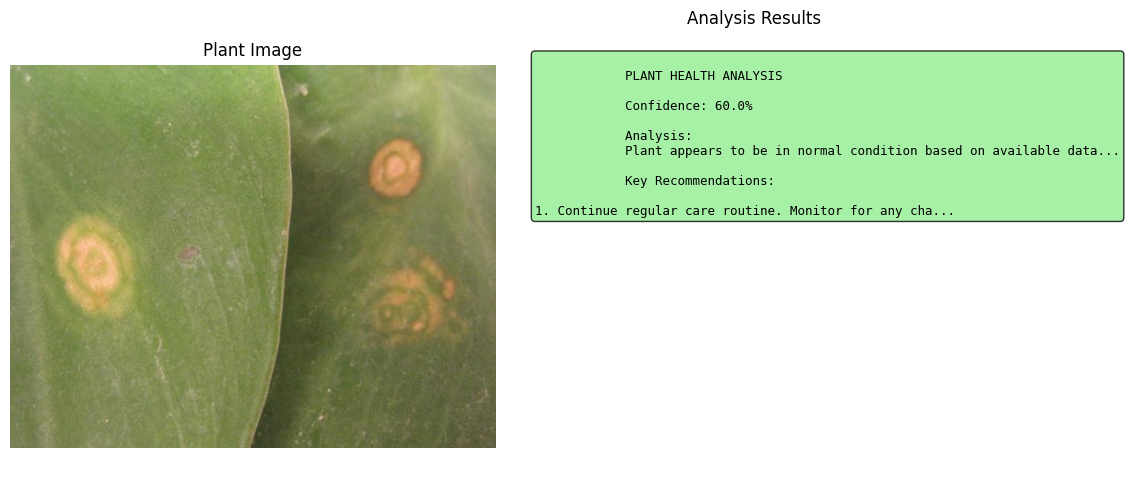

📊 Visualization saved: plant_analysis_output/visualization_20250731_090708.png
✅ Analysis complete!

🌿 PLANT HEALTH ANALYSIS RESULTS
📸 Image: /kaggle/input/testdata/4-_philodendron_pdic.jpg
🎤 Audio: /kaggle/input/testdata/plant_question_offline.wav
💬 Description: What is this plant name and is it healthy? If not, can you recommend treatment?
🎯 Confidence: 60.0%

📋 Analysis:
Plant appears to be in normal condition based on available data

💡 Recommendations:
1. Continue regular care routine. Monitor for any changes in plant health. (Confidence: 50.0%)


In [10]:
result = run_analysis('/kaggle/input/testdata/4-_philodendron_pdic.jpg', '/kaggle/input/testdata/plant_question_offline.wav')